In [1]:
import numpy as np
import torch
import pandas as pd
import torchvision
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm.notebook import tqdm
from typing import Optional

/home/sasha/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:

class Classifier(nn.Module): 
    def __init__(self, classes: int = 10): 
        super().__init__() 
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) 
        self.pool = nn.MaxPool2d(2, 2) 
        #self.dropout1 = nn.Dropout2d(0.25) 
        #self.dropout2 = nn.Dropout2d(0.5) 
        self.fc1 = nn.Linear(64 * 7 * 7, 128) 
        self.fc2 = nn.Linear(128, classes) 
  
    def forward(self, x): 
        x = self.pool(F.relu(self.conv1(x))) 
        #x = self.dropout1(x) 
        x = self.pool(F.relu(self.conv2(x))) 
        #x = self.dropout2(x) 
        x = x.view(-1, 64 * 7 * 7) 
        x = F.relu(self.fc1(x)) 
        x = self.fc2(x) 
        return x

In [3]:
from src.methods.bayes.variational.net import BayesVarLogNormModule, VarBayesModuleNet
from src.methods.bayes.variational.optimization import NormLogVarKLLoss


In [4]:
test_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [5]:
module = Classifier()

In [6]:
#bayes_model = BayesModule(module)
var_module = BayesVarLogNormModule(module)
bayes_model = VarBayesModuleNet(module, nn.ModuleList([var_module]))

In [7]:
print(bayes_model)

VarBayesModuleNet(
  (module_list): ModuleList(
    (0): BayesVarLogNormModule(
      (base_module): Classifier(
        (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (fc1): Linear(in_features=3136, out_features=128, bias=True)
        (fc2): Linear(in_features=128, out_features=10, bias=True)
      )
      (posterior_params): ParameterDict(
          (param_mus): Object of type: ParameterList
          (param_std_log): Object of type: ParameterList
          (scale_alphas_log): Object of type: ParameterList
          (scale_mus): Object of type: ParameterList
        (param_mus): ParameterList(
            (0): Parameter containing: [torch.float32 of size 32x1x3x3]
            (1): Parameter containing: [torch.float32 of size 32]
            (2): Parameter containing: [torch.flo

In [8]:
cnt = 0
for i, p in enumerate(bayes_model.parameters()):
    cnt += 1
print(cnt)

40


In [9]:
a = torch.tensor([[0, 2.], [3, 0]])
b =  torch.tensor([1., 1.])
a_s = a.to_sparse()
print(a_s @ b)

tensor([2., 3.])


In [10]:
optimizer = optim.Adam(bayes_model.parameters(), lr=0.1)

In [11]:
image, label = test_dataset[10]
y = bayes_model(torch.ones_like(image))
kl_loss = NormLogVarKLLoss()

out = y.sum() + kl_loss(bayes_model.posterior_params)
optimizer.zero_grad() 
out.backward() 
optimizer.step() 

In [12]:
bayes_model.prune({'threshold': -2.2})

In [13]:
bayes_model.set_map_params()

In [14]:
bayes_model.state_dict()

OrderedDict([('module_list.0.base_module.conv1.weight',
              tensor([[[[ 8.2426e-02, -2.1409e-01,  2.2546e-01],
                        [ 1.5041e-01, -1.5124e-01, -1.1432e-01],
                        [ 3.3065e-02, -1.2081e-01,  7.4744e-02]]],
              
              
                      [[[-0.0000e+00, -1.0339e-01,  1.8302e-03],
                        [ 1.5963e-01, -1.3430e-02, -3.3177e-02],
                        [-2.0778e-01, -6.6955e-02, -1.2400e-01]]],
              
              
                      [[[ 1.7317e-01,  1.6143e-01,  1.9369e-01],
                        [-9.7242e-03, -5.8778e-02,  0.0000e+00],
                        [-2.2932e-01, -1.0532e-01, -9.1553e-02]]],
              
              
                      [[[ 7.2314e-02,  5.2836e-03, -1.4307e-01],
                        [-0.0000e+00, -2.3045e-01, -0.0000e+00],
                        [-2.0935e-01,  4.6934e-02, -8.1498e-02]]],
              
              
                      [[[-1.0922e-01

In [15]:
print(bayes_model(torch.zeros_like(image)))
#print(bayes_model(torch.zeros_like(image), sample = False))
print(module(torch.zeros_like(image)))

tensor([[-20.2133, -24.5654, -10.8166, -20.1255, -15.8121, -16.5524, -16.2683,
         -17.9500, -16.6813, -20.5781]], grad_fn=<AddmmBackward0>)
tensor([[-20.2133, -24.5654, -10.8166, -20.1255, -15.8121, -16.5524, -16.2683,
         -17.9500, -16.6813, -20.5781]], grad_fn=<AddmmBackward0>)


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
device

device(type='cuda')

In [17]:
from src.methods.bayes.variational.trainer import VarBayesTrainer, VarTrainerParams, Beta_Shelduer_Plato
from src.methods.report.base import ReportChain
from src.methods.report.variational import VarBaseReport

In [18]:
beta = Beta_Shelduer_Plato()

In [19]:
x = torch.tensor([1., 2.], requires_grad=True)
print(x)
y = x ** 2
print(y)
z = nn.Parameter(y)
l = z.sum()
print(z)
l.backward()
print(z)
print(x)

tensor([1., 2.], requires_grad=True)
tensor([1., 4.], grad_fn=<PowBackward0>)
Parameter containing:
tensor([1., 4.], requires_grad=True)
Parameter containing:
tensor([1., 4.], requires_grad=True)
tensor([1., 2.], requires_grad=True)


In [20]:
BATCH_SIZE=1000
EPOCHS=1000
LR = 5e-4 #5e-4
# Split the training set into training and validation sets 
VAL_PERCENT = 0.2 # percentage of the data used for validation 
SAMPLES = 10
BETA = 0.01 #5e-5
BETA_FAC = 5e-1
PRUNE = -2.1#-1.99, -2.1
PLATO_TOL = 10

base_module = Classifier()
var_module = BayesVarLogNormModule(base_module)
model = VarBayesModuleNet(base_module, nn.ModuleList([var_module]))


optimizer = optim.Adam(model.parameters(), lr=LR)

fit_loss = nn.CrossEntropyLoss() 
kl_loss = NormLogVarKLLoss()

beta = Beta_Shelduer_Plato(BETA, BETA_FAC, PLATO_TOL)
beta_KL = Beta_Shelduer_Plato(beta.beta, 1 / BETA_FAC, PLATO_TOL, ref = beta, threshold=1e-4)

model.to(device) 
train_params = VarTrainerParams(EPOCHS, optimizer,fit_loss, kl_loss, SAMPLES, BATCH_SIZE, VAL_PERCENT, PRUNE, beta, beta_KL)
trainer = VarBayesTrainer(train_params, ReportChain([VarBaseReport()]), train_dataset)
trainer.train(model)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/1000],Loss:30379.326171875, KL Loss: 3037738.25. FitLoss: 1.9451096057891846,Accuracy:0.522,Validation Loss:60758.658203125,Validation Accuracy:0.581, Prune parameters: 22024.0/0,Beta: 0.01
Epoch [2/1000],Loss:30352.53125, KL Loss: 3035126.75. FitLoss: 1.2641295194625854,Accuracy:0.727,Validation Loss:60705.08984375,Validation Accuracy:0.737, Prune parameters: 22805.0/0,Beta: 0.01


KeyboardInterrupt: 

In [21]:
base_module.state_dict()

OrderedDict()

In [ ]:
torch.save(model.state_dict(), 'model_bayes.pt' )

In [ ]:
model.prune({'threshold': -2.2})
print(model.prune_stats())

tensor(47343., device='cuda:0')


In [ ]:
model.prune([{'threshold': -2.2}])
print(model.prune_stats())

tensor(47343., device='cuda:0')


In [ ]:
module = Classifier()
var_module = BayesVarLogNormModule(module)
model_loaded = VarBayesModuleNet(module, nn.ModuleList([var_module]))

In [ ]:
model.state_dict()

OrderedDict([('module_list.0.posterior_params.param_mus.0',
              tensor([[[[-2.7887e-01, -2.5056e-01, -1.9260e-03],
                        [-8.0997e-02,  3.2310e-01, -1.6429e-02],
                        [-1.4429e-01,  2.6189e-01, -4.4266e-03]]],
              
              
                      [[[ 2.1482e-01,  2.2142e-01, -1.3183e-01],
                        [ 2.3476e-01, -5.0928e-02, -2.5980e-01],
                        [ 5.7371e-02,  1.1684e-01, -7.0118e-03]]],
              
              
                      [[[ 2.5575e-01,  1.9574e-01,  2.6913e-01],
                        [-4.1178e-03, -7.0739e-02,  1.4407e-01],
                        [-8.0333e-02, -4.2665e-02, -6.4261e-02]]],
              
              
                      [[[-3.1080e-02,  1.9326e-01, -3.0212e-01],
                        [-2.9179e-01, -1.2809e-01,  2.2893e-01],
                        [-9.5503e-02, -6.1782e-02,  3.2568e-01]]],
              
              
                      [[[-2.0041

In [ ]:
model_loaded.load_state_dict(model.state_dict())

<All keys matched successfully>

In [ ]:
model.set_map_params()

In [ ]:
print(model.base_module.state_dict())

OrderedDict([('conv1.weight', tensor([[[[-0.0496, -0.0982,  0.1256],
          [ 0.2083,  0.1721, -0.0053],
          [ 0.2626, -0.0479,  0.2913]]],


        [[[-0.1127, -0.0000,  0.3395],
          [-0.2750,  0.1246, -0.0028],
          [ 0.3075, -0.1812, -0.0636]]],


        [[[-0.1349,  0.2607,  0.0000],
          [ 0.0000,  0.0509,  0.0565],
          [ 0.3370,  0.0328,  0.3101]]],


        [[[ 0.1198,  0.0219, -0.1648],
          [-0.3112,  0.2014,  0.1315],
          [-0.3256, -0.0490,  0.0000]]],


        [[[-0.2555, -0.3065, -0.0267],
          [-0.1459, -0.2665, -0.2776],
          [ 0.0125,  0.0597,  0.2187]]],


        [[[ 0.2959, -0.0000,  0.2131],
          [-0.1276,  0.0441,  0.0000],
          [-0.3048,  0.1082, -0.1318]]],


        [[[-0.1543, -0.2994,  0.0319],
          [-0.1019,  0.3330,  0.0114],
          [ 0.0755,  0.1793, -0.1847]]],


        [[[-0.2003, -0.0858,  0.2435],
          [-0.1356, -0.2054, -0.2101],
          [ 0.2616, -0.1232, -0.0000]]],


  

In [ ]:
print(model.state_dict())

OrderedDict([('module_list.0.base_module.conv1.weight', tensor([])), ('module_list.0.base_module.conv1.bias', tensor([])), ('module_list.0.base_module.conv2.weight', tensor([])), ('module_list.0.base_module.conv2.bias', tensor([])), ('module_list.0.base_module.fc1.weight', tensor([])), ('module_list.0.base_module.fc1.bias', tensor([])), ('module_list.0.base_module.fc2.weight', tensor([])), ('module_list.0.base_module.fc2.bias', tensor([])), ('module_list.0.posterior_params.param_mus.0', tensor([[[[-2.7887e-01, -2.5056e-01, -1.9260e-03],
          [-8.0997e-02,  3.2310e-01, -1.6429e-02],
          [-1.4429e-01,  2.6189e-01, -4.4266e-03]]],


        [[[ 2.1482e-01,  2.2142e-01, -1.3183e-01],
          [ 2.3476e-01, -5.0928e-02, -2.5980e-01],
          [ 5.7371e-02,  1.1684e-01, -7.0118e-03]]],


        [[[ 2.5575e-01,  1.9574e-01,  2.6913e-01],
          [-4.1178e-03, -7.0739e-02,  1.4407e-01],
          [-8.0333e-02, -4.2665e-02, -6.4261e-02]]],


        [[[-3.1080e-02,  1.9326e-01, 

In [ ]:
model_loaded.load_state_dict(torch.load('model_bayes.pt'))
image1, label1 = test_dataset[10]
image2, label2 = test_dataset[11]
model_loaded(image1)

tensor([[-0.0332, -0.0438, -0.0159, -0.0027, -0.0390,  0.0047, -0.0176, -0.0371,
         -0.0069,  0.0396]], grad_fn=<AddmmBackward0>)

In [ ]:
val_loss = 0.0
val_acc = 0.0
PRUNE = -2.2
test_loader = torch.utils.data.DataLoader(test_dataset,  
                                         batch_size=BATCH_SIZE,  
                                         shuffle=False, 
                                         pin_memory=True) 
kl_loss = NormLogVarKLLoss()
model.prune({'threshold': PRUNE})
model.set_map_params()
cnt_prune_parameters = model.prune_stats()
with torch.no_grad(): 
        for images, labels in test_loader: 
            labels=labels.to(device) 
            images=images.to(device) 
            fit_loss_total = 0 
            for j in range(SAMPLES):
                
                outputs = model(images)
                KL_loss_total = kl_loss(model.posterior_params)
                # calculate fit loss based on mean and standard deviation of output
                fit_loss_total = fit_loss_total + fit_loss(outputs, labels)  
            total_loss = (fit_loss_total)/(SAMPLES) + float(beta)* KL_loss_total
            val_loss += total_loss.item() 
              
            _, predicted = torch.max(outputs.data, 1) 
        total = labels.size(0) 
        
        correct = (predicted == labels).sum().item() 
        val_acc += correct / total 
        cnt_params = model.total_params()
print(f'Loss:{val_loss}, KL Loss: {KL_loss_total}, FitLoss: {fit_loss_total / SAMPLES}, Accuracy {val_acc}, Prune parameters: {cnt_prune_parameters}/{cnt_params}, Beta: {float(beta)}')

Loss:1814476.833984375, KL Loss: 3024081.0, FitLoss: 0.36089444160461426, Accuracy 0.899, Prune parameters: 47343.0/0, Beta: 0.01


Label: 3


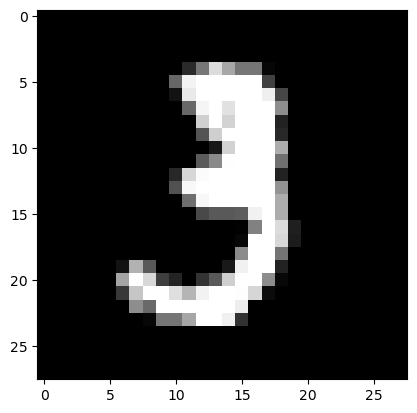

In [ ]:
image, label = test_dataset[10]
plt.imshow(image.permute(1, 2, 0), cmap = 'gray')
print('Label:', label)

In [ ]:
torch.max(model(image.cuda()).data, 1)

torch.return_types.max(
values=tensor([6.1152], device='cuda:0'),
indices=tensor([3], device='cuda:0'))